# fixed traffic timing

In [131]:
import traci
import pytz
import datetime
import pandas as pd

# Initialize simulation timer
simulation_time = 0

# Function to get the simulation time
def get_simulation_time():
    global simulation_time
    minutes, seconds = divmod(simulation_time, 60)
    hours, minutes = divmod(minutes, 60)
    return f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}"

# Function to flatten nested lists
def flatten_list(_2d_list):
    flat_list = []
    for element in _2d_list:
        if type(element) is list:
            flat_list.extend(flatten_list(element))
        else:
            flat_list.append(element)
    return flat_list

# Function to add a new vehicle dynamically
vehicle_id_counter = 0
def add_vehicle():
    global vehicle_id_counter
    veh_id = f"veh{vehicle_id_counter}"
    route_id = "route0"  
    try:
        traci.vehicle.add(veh_id, route_id)
        print(f"Vehicle {veh_id} added to the simulation.")
    except traci.TraCIException as e:
        print(f"Error adding vehicle {veh_id}: {e}")
    vehicle_id_counter += 1

sumoCmd = [r"C:\Program Files (x86)\Eclipse\Sumo\bin\sumo.exe", "-c", r"C:\Users\linam\Sumo\2024-10-16-01-22-19\osm.sumocfg"]

packBigData = []
traffic_flow = {}
lane_congestion = {}
total_waiting_time = 0
waiting_vehicle_count = 0
road_speeds = {}
light_switch_frequency = {}
vehicle_counts = {}  
last_counted = {}

fixed_phase_durations = [30, 5, 25]  # Red, Yellow, Green in seconds
phase_duration = fixed_phase_durations[0]  # Start with Red phase
current_phase = 0
step_counter = 0

trafficlights = []

# Start the SUMO simulation
try:
    traci.start(sumoCmd)
    print("SUMO connection established successfully.")
    
    # Main simulation loop
    while traci.simulation.getMinExpectedNumber() > 0:
        traci.simulationStep()  # Advance the simulation by 1 step
        step_counter += 1

        simulation_time += 1
        current_sim_time = get_simulation_time()
        
        # Dynamically add vehicles periodically (every 50 simulation steps)
        if step_counter % 50 == 0:
            add_vehicle()

        # Update traffic light based on fixed timers
        if step_counter >= phase_duration:
            current_phase = (current_phase + 1) % 3
            phase_duration = fixed_phase_durations[current_phase]
            step_counter = 0  # Reset step counter
            
            # Dynamically retrieve all traffic light IDs
            try:
                trafficlights = traci.trafficlight.getIDList()  # Fetch traffic lights
            except traci.TraCIException as e:
                print(f"Error retrieving traffic light IDs: {e}")
                trafficlights = []
            for tf1 in trafficlights:
                if tf1 not in vehicle_counts:
                    vehicle_counts[tf1]=0
                
            # Control each traffic light based on the current phase
            if trafficlights:  # Only proceed if `trafficlights` is not empty
                for tfl in trafficlights:
                    try:
                        controlled_lanes = traci.trafficlight.getControlledLanes(tfl)
                        num_lanes = len(controlled_lanes)
                        if current_phase == 0:
                            traci.trafficlight.setRedYellowGreenState(tfl, "r" * num_lanes)
                        elif current_phase == 1:
                            traci.trafficlight.setRedYellowGreenState(tfl, "y" * num_lanes)
                        elif current_phase == 2:
                            traci.trafficlight.setRedYellowGreenState(tfl, "g" * num_lanes)
                        
                        if tfl not in light_switch_frequency:
                            light_switch_frequency[tfl] = 0
                        light_switch_frequency[tfl] += 1

                    except traci.TraCIException as e:
                        print(f"Error controlling traffic light {tfl}: {e}")
                        continue
    

        # Collect vehicle data
        vehicles = traci.vehicle.getIDList()
        for vehid in vehicles:
            veh_type = traci.vehicle.getVehicleClass(vehid) 
            nextTLS = traci.vehicle.getNextTLS(vehid)
            if nextTLS and len(nextTLS) > 0:
                tfl = nextTLS[0][0]
                if tfl in trafficlights:
                    # Get current simulation time
                    current_time = traci.simulation.getCurrentTime()

                    if tfl not in last_counted or (current_time - last_counted[tfl]) > 1000:  
                        vehicle_counts[tfl] += 1
                        last_counted[tfl] = current_time  # Update the last counted time

            x, y = traci.vehicle.getPosition(vehid)
            gpscoord = traci.simulation.convertGeo(x, y)
            spd = round(traci.vehicle.getSpeed(vehid) * 3.6, 2)
            edge = traci.vehicle.getRoadID(vehid)
            lane = traci.vehicle.getLaneID(vehid)
            displacement = round(traci.vehicle.getDistance(vehid), 2)
            turnAngle = round(traci.vehicle.getAngle(vehid), 2)
            nextTLS = traci.vehicle.getNextTLS(vehid)

            if lane not in traffic_flow:
                traffic_flow[lane] = 0
            traffic_flow[lane] += 1

            if lane not in lane_congestion:
                lane_congestion[lane] = 0
            waiting_time = traci.vehicle.getWaitingTime(vehid) 
            lane_congestion[lane] += waiting_time  

          
            if edge not in road_speeds:
                road_speeds[edge] = []
            road_speeds[edge].append(spd)

            waiting_time = traci.vehicle.getWaitingTime(vehid)
            total_waiting_time += waiting_time
            if waiting_time > 0:
                waiting_vehicle_count += 1

            vehList = [current_sim_time, vehid, (x, y), gpscoord, spd, edge, lane, displacement, turnAngle, nextTLS]
            tlsList = []

            # Collect traffic light data
            if trafficlights:  
                for tfl in trafficlights:
                    if lane in traci.trafficlight.getControlledLanes(tfl):
                        tflight = tfl
                        tl_state = traci.trafficlight.getRedYellowGreenState(tflight)
                        tlsList = [tflight, tl_state]
            # Logical handling of null traffic light values
            if not tlsList:  # If there was no traffic light interaction
                tlsList = ["None", "None"]  # Set logical default values

            packBigDataLine = flatten_list([vehList, tlsList])
            
            # Ensure the data includes default values for missing fields (if any)
            while len(packBigDataLine) < 11:  
                packBigDataLine.append("None")  
            if packBigDataLine[10] != "None" and packBigDataLine[11] != "None":  # 10th and 11th indices correspond to tflight and tl_state
                packBigData.append(packBigDataLine)

except Exception as e:
    print(f"Simulation error: {e}")

finally:
    try:
        traci.close()  # Close the SUMO TraCI connection
    except:
        pass

# Compute average waiting time
average_waiting_time = total_waiting_time / waiting_vehicle_count if waiting_vehicle_count > 0 else 0

# Compute average speed on each road
for road, speeds in road_speeds.items():
    avg_speed = sum(speeds) / len(speeds) if speeds else 0
    print(f"Average speed on road {road}: {avg_speed} m/s")

columnnames = ['dateandtime', 'vehid', 'coord', 'gpscoord', 'spd', 'edge', 'lane', 'displacement', 'turnAngle', 'nextTLS',
               'tflight', 'tl_state', 'traffic_flow_rate', 'average_waiting_time', 'lane_congestion', 'light_switch_frequency', 'avg_speed', 'vehicle_count']
for row in packBigData:
    if len(row) > 10:  # Check if the row has at least 11 elements
        lane = row[6]
        traffic_flow_rate = traffic_flow.get(lane, 0)
        congestion_level = lane_congestion.get(lane, 0)
        tflight = row[10] if len(row) > 10 else "None"  # Fill "None" for missing traffic light
        vehicle_count = vehicle_counts.get(tflight, 0)  # Retrieve vehicle count for the traffic light
        row.extend([traffic_flow_rate, average_waiting_time, congestion_level, light_switch_frequency.get(tflight, 0), road_speeds.get(row[5], [0]), vehicle_count])
    else:
        # If some fields are missing, add default values
        row.extend([0, 0, 0, 0, 0, 0])  # Default values for missing fields (e.g., 0 for numeric, "None" for text)

dataset = pd.DataFrame(packBigData, columns=columnnames)
try:
    dataset.to_csv(r"C:\Users\linam\traffic_sim_sumo_fixed_with_vehicle_counts.csv", index=False)
    print("File saved successfully")
except Exception as e:
    print(f"Error saving file: {e}")


SUMO connection established successfully.


C:\Users\linam\AppData\Local\Temp\ipykernel_9544\1313088304.py:128: UserWarning: getCurrentTime is deprecated, please use getTime which returns floating point seconds
  current_time = traci.simulation.getCurrentTime()


Average speed on road 156725108: 18.729230769230767 m/s
Average speed on road 51144623#3: 66.41153846153848 m/s
Average speed on road -32529421#4: 35.98968253968254 m/s
Average speed on road 690729137#0: 43.13837209302327 m/s
Average speed on road 142592728#3: 30.696969696969695 m/s
Average speed on road 156738544#0: 33.52222222222222 m/s
Average speed on road -141032889: 32.191500000000005 m/s
Average speed on road 673822476: 20.673333333333336 m/s
Average speed on road -703241472: 64.82333333333332 m/s
Average speed on road -691761717: 38.45826086956522 m/s
Average speed on road -150990409#2: 37.235 m/s
Average speed on road 156725163#1: 35.384523809523806 m/s
Average speed on road -156771724#1: 63.95493975903612 m/s
Average speed on road 673837625#4: 36.578 m/s
Average speed on road 689702001#5-AddedOffRampEdge: 3.360963287302126 m/s
Average speed on road 673823513#1: 44.07449275362319 m/s
Average speed on road 150978417#2: 33.635 m/s
Average speed on road 674689988#0-AddedOffRampEd

# optimized traffic lighting

In [133]:
import traci
import pandas as pd
import random

# Initialize simulation timer
simulation_time = 0

# Function to get the simulation time
def get_simulation_time():
    global simulation_time
    minutes, seconds = divmod(simulation_time, 60)
    hours, minutes = divmod(minutes, 60)
    return f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}"

# Function to flatten nested lists
def flatten_list(_2d_list):
    flat_list = []
    for element in _2d_list:
        if isinstance(element, list):
            flat_list.extend(flatten_list(element))
        else:
            flat_list.append(element)
    return flat_list

# Function to add a new vehicle dynamically
vehicle_id_counter = 0
def add_vehicle():
    global vehicle_id_counter
    veh_id = f"veh{vehicle_id_counter}"
    route_id = "route0"  
    try:
        traci.vehicle.add(veh_id, route_id)
        print(f"Vehicle {veh_id} added to the simulation.")
    except traci.TraCIException as e:
        print(f"Error adding vehicle {veh_id}: {e}")
    vehicle_id_counter += 1

# Initialize SUMO
sumoCmd = [r"C:\Program Files (x86)\Eclipse\Sumo\bin\sumo.exe", "-c", r"C:\Users\linam\Sumo\2024-10-16-01-22-19\osm.sumocfg"]

packBigData = []
traffic_flow = {}
lane_congestion = {}
road_speeds = {}
light_switch_frequency = {}
total_waiting_time = 0
waiting_vehicle_count = 0

# Genetic Algorithm Parameters
population_size = 10
generations = 20
mutation_rate = 0.1
chromosome_length = 3  # Representing [green_duration, yellow_duration, red_duration]

# Generate a random initial population for each intersection
def generate_population(size, trafficlights):
    return {tfl: [[random.randint(10, 60), random.randint(3, 10), random.randint(20, 60)] for _ in range(size)] for tfl in trafficlights}

# Fitness Function: Now includes coordination between intersections
def fitness(chromosome, intersection_offsets, tfl):
    green_time, yellow_time, red_time = chromosome
    total_waiting_time = 0
    inter_coordination_penalty = 0
    vehicle_penalty = 0
    
    # Calculate the waiting time at the current intersection
    for vehid in traci.vehicle.getIDList():
        total_waiting_time += traci.vehicle.getWaitingTime(vehid)
    
    # Penalize based on vehicle count at the intersection
    vehicle_penalty = vehicle_counts.get(tfl, 0) * 10  # Adjust the weight of this penalty as needed
    
    # Coordination penalty
    if tfl in intersection_offsets:
        for tfl_b in intersection_offsets[tfl]:
            offset_a_to_b = intersection_offsets[tfl][tfl_b]
            if offset_a_to_b > (green_time + yellow_time):
                inter_coordination_penalty += (offset_a_to_b - (green_time + yellow_time)) * 5
    
    # Introduce a small random noise to prevent identical fitness scores
    random_noise = random.uniform(0.001, 0.01)
    
    # Fitness function takes waiting time, coordination penalty, and vehicle penalty into account
    fitness_value = 1 / (1 + total_waiting_time + inter_coordination_penalty + vehicle_penalty + random_noise)
    
    return fitness_value

# Selection: Select best-performing chromosomes
def selection(population, fitness_scores):
    selected = random.choices(population, weights=fitness_scores, k=2)
    return selected

# Crossover: Combine two parents to create offspring
def crossover(parent1, parent2):
    cross_point = random.randint(1, chromosome_length - 1)
    child1 = parent1[:cross_point] + parent2[cross_point:]
    child2 = parent2[:cross_point] + parent1[cross_point:]
    return child1, child2

# Mutation: Mutate a chromosome
def mutate(chromosome):
    if random.random() < mutation_rate:
        mutate_point = random.randint(0, chromosome_length - 1)
        chromosome[mutate_point] = random.randint(10, 60)  # Random new duration

# Evolve population: Create new population from the old one
def evolve_population(population, intersection_offsets, trafficlights):
    new_population = {}
    for tfl in trafficlights:
        fitness_scores = [fitness(chromosome, intersection_offsets, tfl) for chromosome in population[tfl]]
        best_chromosome = max(population[tfl], key=lambda x: fitness(x, intersection_offsets, tfl))
        best_fitness = fitness(best_chromosome, intersection_offsets, tfl)
        print(f"Best fitness score for traffic light {tfl} in this generation: {best_fitness}")
        
        new_population[tfl] = []
        for _ in range(len(population[tfl]) // 2):
            parent1, parent2 = selection(population[tfl], fitness_scores)
            child1, child2 = crossover(parent1, parent2)
            mutate(child1)
            mutate(child2)
            new_population[tfl].extend([child1, child2])
    return new_population

# Initialize traffic light timings for each intersection
intersection_timings = {}

# Dynamic Offset Calculation Based on Travel Time Between Intersections
def calculate_dynamic_offsets(trafficlights):
    offsets = {}
    for veh_id in traci.vehicle.getIDList():
        current_edge = traci.vehicle.getRoadID(veh_id)
        next_tls = traci.vehicle.getNextTLS(veh_id)
        
        if next_tls:
            intersection_from = current_edge
            intersection_to = next_tls[0][0]
            travel_time = traci.vehicle.getTravelTime(veh_id)
            
            if intersection_from not in offsets:
                offsets[intersection_from] = {}
            offsets[intersection_from][intersection_to] = travel_time
    
    return offsets

# Start the SUMO simulation
try:
    traci.start(sumoCmd)
    print("SUMO connection established successfully.")
    
    # Initialize traffic light population
    trafficlights = traci.trafficlight.getIDList()
    vehicle_counts = {tfl: 0 for tfl in trafficlights}  # Initialize vehicle count for each traffic light

    population = generate_population(population_size, trafficlights)
    intersection_offsets = calculate_dynamic_offsets(trafficlights)
    
    # Run genetic algorithm for N generations
    for generation in range(generations):
        print(f"Generation {generation+1}/{generations}")
        population = evolve_population(population, intersection_offsets, trafficlights)
        
        # Apply best timings to traffic lights
        for tfl in trafficlights:
            best_chromosome = max(population[tfl], key=lambda x: fitness(x, intersection_offsets, tfl))
            intersection_timings[tfl] = best_chromosome
        
        # Simulation step
        previous_state = {}
        while traci.simulation.getMinExpectedNumber() > 0:
            traci.simulationStep()
            simulation_time += 1
            current_sim_time = get_simulation_time()
            # Update traffic light based on fixed timers
            if step_counter >= phase_duration:
                current_phase = (current_phase + 1) % 3  # Move to the next phase
                phase_duration = fixed_phase_durations[current_phase]  # Update based on new phase
                step_counter = 0  # Reset step counter for the new phase

                for tfl in trafficlights:
                    vehicle_counts[tfl] = 0  # Reset vehicle count after the phase ends

            for tfl in trafficlights:
                timings = intersection_timings[tfl]
                green_duration, yellow_duration, red_duration = timings
                
                controlled_lanes = traci.trafficlight.getControlledLanes(tfl)
                vehicle_list = traci.vehicle.getIDList()
                
                # Handle light switch states
                current_state = traci.trafficlight.getRedYellowGreenState(tfl)
                if tfl not in previous_state:
                    previous_state[tfl] = current_state
                
                if current_state != previous_state[tfl]:
                    if tfl not in light_switch_frequency:
                        light_switch_frequency[tfl] = 0
                    light_switch_frequency[tfl] += 1
                previous_state[tfl] = current_state

                # Count vehicles passing through controlled lanes
                for vehid in vehicle_list:
                    lane_id = traci.vehicle.getLaneID(vehid)
                    if lane_id in controlled_lanes:
                        vehicle_counts[tfl] += 1  

            # Collect vehicle and traffic light data
            vehicles = traci.vehicle.getIDList()
            for vehid in vehicles:
                x, y = traci.vehicle.getPosition(vehid)
                gpscoord = traci.simulation.convertGeo(x, y)
                spd = round(traci.vehicle.getSpeed(vehid) * 3.6, 2)
                edge = traci.vehicle.getRoadID(vehid)
                lane = traci.vehicle.getLaneID(vehid)
                displacement = round(traci.vehicle.getDistance(vehid), 2)
                turnAngle = round(traci.vehicle.getAngle(vehid), 2)
                nextTLS = traci.vehicle.getNextTLS(vehid)

                if lane not in traffic_flow:
                    traffic_flow[lane] = 0
                traffic_flow[lane] += 1

                if lane not in lane_congestion:
                    lane_congestion[lane] = 0
                waiting_time = traci.vehicle.getWaitingTime(vehid)
                lane_congestion[lane] += waiting_time

                if edge not in road_speeds:
                    road_speeds[edge] = []
                road_speeds[edge].append(spd)

                waiting_time = traci.vehicle.getWaitingTime(vehid)
                total_waiting_time += waiting_time
                if waiting_time > 0:
                    waiting_vehicle_count += 1

                vehList = [current_sim_time, vehid, (x, y), gpscoord, spd, edge, lane, displacement, turnAngle, nextTLS]
                tlsList = []

                # Collect traffic light data
                for tfl in trafficlights:
                    if lane in traci.trafficlight.getControlledLanes(tfl):
                        tflight = tfl
                        tl_state = traci.trafficlight.getRedYellowGreenState(tflight)
                        tlsList = [tflight, tl_state]

                if not tlsList or tlsList[0] == "None" or tlsList[1] == "None":
                    continue  # Skip this record if tflight or tl_state are "None"

                packBigDataLine = flatten_list([vehList, tlsList])
                packBigData.append(packBigDataLine)

        print(f"Best timings so far for this generation: Green: {green_duration}s, Yellow: {yellow_duration}s, Red: {red_duration}s")

except Exception as e:
    print(f"Simulation error: {e}")

finally:
    try:
        traci.close()
    except:
        pass
        
columnnames = ['dateandtime', 'vehid', 'coord', 'gpscoord', 'spd', 'edge', 'lane', 'displacement', 'turnAngle', 'nextTLS',
               'tflight', 'tl_state', 'traffic_flow_rate', 'average_waiting_time', 'lane_congestion', 'light_switch_frequency', 'avg_speed', 'vehicle_count']

for row in packBigData:
    if len(row) > 10:  
        lane = row[6]
        traffic_flow_rate = traffic_flow.get(lane, 0)
        congestion_level = lane_congestion.get(lane, 0)
        tflight = row[10] if len(row) > 10 else "None"  # Fill "None" for missing traffic light
        vehicle_count = vehicle_counts.get(tflight, 0)  # Get vehicle count for this traffic light
        avg_speed = road_speeds.get(row[5], [0])  # Ensure avg_speed is a single value or default to 0
        row.extend([traffic_flow_rate, average_waiting_time, congestion_level, light_switch_frequency.get(tflight, 0), avg_speed[0], vehicle_count])
    else:
        row.extend([0, 0, 0, 0, 0, 0])  # Default values for missing fields

dataset = pd.DataFrame(packBigData, columns=columnnames)
try:
    dataset.to_csv(r"C:\Users\linam\traffic_sim_ga_op_final_ver.csv", index=False)
    print("File saved successfully")
except Exception as e:
    print(f"Error saving file: {e}")


SUMO connection established successfully.
Generation 1/20
Best fitness score for traffic light GS_cluster_1512225643_1566541953_1566541954_1566541955 in this generation: 0.9914707823990702
Best fitness score for traffic light GS_cluster_1517116450_1632064521_1632064522_675488445 in this generation: 0.9904600746804276
Best fitness score for traffic light GS_cluster_1566541956_652570350 in this generation: 0.9965724787354086
Best fitness score for traffic light GS_cluster_1628275216_1628275220 in this generation: 0.9967431430261251
Best fitness score for traffic light GS_cluster_2851883153_2851883154_361352842_6489419269 in this generation: 0.9953174455717624
Best fitness score for traffic light GS_cluster_6243198464_6243198465_6243198466_6243198467 in this generation: 0.9987220038758309
Best fitness score for traffic light GS_cluster_6470496298_6470503277_9375724358_9375724361_#1more in this generation: 0.9948319334918806
Best fitness score for traffic light GS_cluster_6491827204_649182

# evaluation

In [140]:
df_fixed=pd.read_csv("traffic_sim_sumo_fixed_with_vehicle_counts.csv")
df_fixed

,dateandtime,vehid,coord,gpscoord,spd,edge,lane,displacement,turnAngle,nextTLS,tflight,tl_state,traffic_flow_rate,average_waiting_time,lane_congestion,light_switch_frequency,avg_speed,vehicle_count
0,00:00:30,veh101,"(3844.3562132533298, 2389.7210313953383)","(35.87009211172751, 31.946758513711693)",0.00,691737292#0,691737292#0_3,50.46,176.89,(('GS_cluster_1517116450_1632064521_1632064522...,GS_cluster_1517116450_1632064521_1632064522_67...,yyyyyyyyyyyyyyyyyyyyyyyy,1709,71.087994,59183.0,141,"[21.39, 27.66, 36.41, 41.36, 25.16, 8.96, 0.89...",1297
1,00:00:30,veh109,"(3839.2429377631074, 3311.2385418646386)","(35.87029646003682, 31.955063094224528)",61.36,691533044#1,691533044#1_0,146.54,92.45,(('GS_cluster_2851883153_2851883154_361352842_...,GS_cluster_2851883153_2851883154_361352842_648...,yyyyyyyyyyyyyyyyyyy,7134,71.087994,244190.0,141,"[65.48, 67.34, 67.81, 61.36, 45.54, 29.34, 74....",676
2,00:00:30,veh127,"(4841.801588707057, 402.28184613704025)","(35.88007369587286, 31.92861190534887)",50.80,383626242#0,383626242#0_0,106.15,252.19,(('GS_cluster_6243198464_6243198465_6243198466...,GS_cluster_6243198464_6243198465_6243198466_62...,yyyyyyyyyyyyyyyyyyyyyyyy,247,71.087994,7963.0,141,"[50.8, 51.4, 47.74, 42.38, 26.18, 13.29, 52.2,...",901
3,00:00:30,veh18,"(4761.31019935019, 359.8895867033366)","(35.879211357068286, 31.92824922464415)",0.00,685637576#0,685637576#0_3,222.71,65.20,(('GS_cluster_6243198464_6243198465_6243198466...,GS_cluster_6243198464_6243198465_6243198466_62...,yyyyyyyyyyyyyyyyyyyyyyyy,154,71.087994,1028.0,141,"[46.64, 46.85, 40.11, 28.0, 15.2, 2.04, 0.12, ...",901
4,00:00:30,veh32,"(1624.3131621211262, 3455.2912126888305)","(35.84692766473324, 31.956888552944804)",0.00,691990432#1,691990432#1_1,272.99,231.42,"(('joinedS_1638076800_6304120066', 7, 1.001045...",joinedS_1638076800_6304120066,yyyyyyyyyyyyyyy,72,71.087994,377.0,141,"[48.39, 32.19, 15.99, 0.68, 0.38, 0.07, 0.01, ...",592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197768,00:45:31,veh776,"(1751.3482014309811, 1013.2335717615771)","(35.847590999860074, 31.934853745425027)",0.00,156738535#5,156738535#5_1,6293.92,198.64,(('GS_cluster_6470496298_6470503277_9375724358...,GS_cluster_6470496298_6470503277_9375724358_93...,yyyyyyyyyyy,183,71.087994,1228.0,141,"[0.0, 5.42, 11.15, 17.51, 46.2, 30.14, 16.94, ...",812
197769,00:45:32,veh776,"(1751.3482014309811, 1013.2335717615771)","(35.847590999860074, 31.934853745425027)",0.00,156738535#5,156738535#5_1,6293.92,198.64,(('GS_cluster_6470496298_6470503277_9375724358...,GS_cluster_6470496298_6470503277_9375724358_93...,yyyyyyyyyyy,183,71.087994,1228.0,141,"[0.0, 5.42, 11.15, 17.51, 46.2, 30.14, 16.94, ...",812
197770,00:45:33,veh776,"(1751.3482014309811, 1013.2335717615771)","(35.847590999860074, 31.934853745425027)",0.00,156738535#5,156738535#5_1,6293.92,198.64,(('GS_cluster_6470496298_6470503277_9375724358...,GS_cluster_6470496298_6470503277_9375724358_93...,yyyyyyyyyyy,183,71.087994,1228.0,141,"[0.0, 5.42, 11.15, 17.51, 46.2, 30.14, 16.94, ...",812
197771,00:45:34,veh776,"(1751.3482014309811, 1013.2335717615771)","(35.847590999860074, 31.934853745425027)",0.00,156738535#5,156738535#5_1,6293.92,198.64,(('GS_cluster_6470496298_6470503277_9375724358...,GS_cluster_6470496298_6470503277_9375724358_93...,yyyyyyyyyyy,183,71.087994,1228.0,141,"[0.0, 5.42, 11.15, 17.51, 46.2, 30.14, 16.94, ...",812


In [141]:
df_optimized=pd.read_csv("traffic_sim_ga_op_final_ver.csv")
df_optimized

,dateandtime,vehid,coord,gpscoord,spd,edge,lane,displacement,turnAngle,nextTLS,tflight,tl_state,traffic_flow_rate,average_waiting_time,lane_congestion,light_switch_frequency,avg_speed,vehicle_count
0,00:00:09,veh19,"(5545.136193969979, 3184.8213384623505)","(35.88828939357586, 31.953514865203726)",34.33,150411280#1,150411280#1_1,30.17,336.43,(('joinedS_1633296157_cluster_1566541951_16332...,joinedS_1633296157_cluster_1566541951_16332961...,rGGGrrrrGGGGggrrrrrrrGGGGgg,67,71.087994,238.0,207,34.33,1248
1,00:00:09,veh50,"(1754.8888863109048, 1023.7328654292343)","(35.84763133123417, 31.934947512265236)",0.00,156738535#5,156738535#5_1,0.00,198.64,(('GS_cluster_6470496298_6470503277_9375724358...,GS_cluster_6470496298_6470503277_9375724358_93...,GGGgGGggrrr,109,71.087994,303.0,197,0.00,564
2,00:00:10,veh19,"(5543.571518766476, 3193.049793003832)","(35.88827517974047, 31.953589383146)",28.54,150411280#1,150411280#1_1,38.10,355.41,(('joinedS_1633296157_cluster_1566541951_16332...,joinedS_1633296157_cluster_1566541951_16332961...,rGGGrrrrGGGGggrrrrrrrGGGGgg,67,71.087994,238.0,207,34.33,1248
3,00:00:10,veh50,"(1754.4102086338637, 1022.3134288869132)","(35.847625878688284, 31.934934835596493)",5.42,156738535#5,156738535#5_1,1.51,198.64,(('GS_cluster_6470496298_6470503277_9375724358...,GS_cluster_6470496298_6470503277_9375724358_93...,GGGgGGggrrr,109,71.087994,303.0,197,0.00,564
4,00:00:11,veh19,"(5544.452333371326, 3196.9770153904424)","(35.88828559657402, 31.953624556993756)",13.85,150411280#1,150411280#1_1,41.95,9.38,(('joinedS_1633296157_cluster_1566541951_16332...,joinedS_1633296157_cluster_1566541951_16332961...,rGGGrrrrGGGGggrrrrrrrGGGGgg,67,71.087994,238.0,207,34.33,1248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68408,00:26:42,veh1035,"(4767.874813848268, 383.8732295821099)","(35.879287454915335, 31.928463755601893)",0.00,1169292240#5,1169292240#5_2,6041.42,153.25,(('GS_cluster_6243198464_6243198465_6243198466...,GS_cluster_6243198464_6243198465_6243198466_62...,rrrryyrrrrrrrrrryyrrrrrr,1206,71.087994,4594.0,248,86.90,1846
68409,00:26:42,veh1126,"(4764.464183350696, 390.64097141110165)","(35.87925332216206, 31.928525553684057)",0.00,1169292240#5,1169292240#5_2,5867.95,153.25,(('GS_cluster_6243198464_6243198465_6243198466...,GS_cluster_6243198464_6243198465_6243198466_62...,rrrryyrrrrrrrrrryyrrrrrr,1206,71.087994,4594.0,248,86.90,1846
68410,00:26:43,veh1126,"(4764.464183350696, 390.64097141110165)","(35.87925332216206, 31.928525553684057)",0.00,1169292240#5,1169292240#5_2,5867.95,153.25,(('GS_cluster_6243198464_6243198465_6243198466...,GS_cluster_6243198464_6243198465_6243198466_62...,rrrrrrGGGGggrrrrrrGGGGgg,1206,71.087994,4594.0,248,86.90,1846
68411,00:26:44,veh1126,"(4765.112596762404, 389.35431940584334)","(35.87925981132773, 31.928513804916932)",5.13,1169292240#5,1169292240#5_2,5869.37,153.25,(('GS_cluster_6243198464_6243198465_6243198466...,GS_cluster_6243198464_6243198465_6243198466_62...,rrrrrrGGGGggrrrrrrGGGGgg,1206,71.087994,4594.0,248,86.90,1846


In [135]:
def compute_stats(df):
    total_vehicles = df['vehid'].nunique()

    total_traffic_flow = df['traffic_flow_rate'].sum()

    average_waiting_time = df['average_waiting_time'].mean()

    total_congestion = df['lane_congestion'].sum()

    print(f"Total vehicles: {total_vehicles}")
    print(f"Total traffic flow: {total_traffic_flow}")
    print(f"Average waiting time: {average_waiting_time:.2f} seconds")
    print(f"Total congestion: {total_congestion}")

print("Fixed Traffic Light Timing Results:")
compute_stats(df_fixed)

print("\nOptimized Traffic Light Timing Results:")
compute_stats(df_optimized)

Fixed Traffic Light Timing Results:
Total vehicles: 1234
Total traffic flow: 1598243036
Average waiting time: 71.09 seconds
Total congestion: 119388876327.0

Optimized Traffic Light Timing Results:
Total vehicles: 1248
Total traffic flow: 127409913
Average waiting time: 71.09 seconds
Total congestion: 4818500500.0


In [136]:
import matplotlib.pyplot as plt

fixed_vehicles_processed = df_fixed['vehid'].nunique()
optimized_vehicles_processed = df_optimized['vehid'].nunique()

fixed_time = (pd.to_datetime(df_fixed['dateandtime'].max()) - pd.to_datetime(df_fixed['dateandtime'].min())).total_seconds() / 60
optimized_time = (pd.to_datetime(df_optimized['dateandtime'].max()) - pd.to_datetime(df_optimized['dateandtime'].min())).total_seconds() / 60


fixed_traffic_flow = df_fixed['traffic_flow_rate'].sum()
optimized_traffic_flow = df_optimized['traffic_flow_rate'].sum()

fixed_avg_waiting_time = df_fixed['average_waiting_time'].mean()
optimized_avg_waiting_time = df_optimized['average_waiting_time'].mean()

fixed_total_congestion = df_fixed['lane_congestion'].sum()
optimized_total_congestion = df_optimized['lane_congestion'].sum()


fixed_vehicles_per_minute = fixed_vehicles_processed / fixed_time
optimized_vehicles_per_minute = optimized_vehicles_processed / optimized_time

efficiency_improvement = ((optimized_vehicles_per_minute - fixed_vehicles_per_minute) / fixed_vehicles_per_minute) * 100

waiting_time_improvement = ((fixed_avg_waiting_time - optimized_avg_waiting_time) / fixed_avg_waiting_time) * 100

fixed_congestion_per_vehicle = fixed_total_congestion / fixed_vehicles_processed
optimized_congestion_per_vehicle = optimized_total_congestion / optimized_vehicles_processed
congestion_improvement = ((fixed_congestion_per_vehicle - optimized_congestion_per_vehicle) / fixed_congestion_per_vehicle) * 100

fixed_flow_per_vehicle = fixed_traffic_flow / fixed_vehicles_processed
optimized_flow_per_vehicle = optimized_traffic_flow / optimized_vehicles_processed
traffic_flow_improvement = ((fixed_flow_per_vehicle - optimized_flow_per_vehicle) / fixed_flow_per_vehicle) * 100

print(f"Fixed Timing - Vehicles Processed per Minute: {fixed_vehicles_per_minute:.2f}")
print(f"Optimized Timing - Vehicles Processed per Minute: {optimized_vehicles_per_minute:.2f}")
print(f"Efficiency Improvement of Optimized Version: {efficiency_improvement:.2f}%")

print(f"Fixed Timing - Average Waiting Time: {fixed_avg_waiting_time:.2f} seconds")
print(f"Optimized Timing - Average Waiting Time: {optimized_avg_waiting_time:.2f} seconds")
print(f"Waiting Time Improvement (Optimized): {waiting_time_improvement:.2f}%")

print(f"Fixed Timing - Congestion per Vehicle: {fixed_congestion_per_vehicle:.2f}")
print(f"Optimized Timing - Congestion per Vehicle: {optimized_congestion_per_vehicle:.2f}")
print(f"Congestion Improvement (Optimized): {congestion_improvement:.2f}%")

print(f"Fixed Timing - Traffic Flow per Vehicle: {fixed_flow_per_vehicle:.2f}")
print(f"Optimized Timing - Traffic Flow per Vehicle: {optimized_flow_per_vehicle:.2f}")
print(f"Traffic Flow Improvement (Optimized): {traffic_flow_improvement:.2f}%")




Fixed Timing - Vehicles Processed per Minute: 27.37
Optimized Timing - Vehicles Processed per Minute: 46.92
Efficiency Improvement of Optimized Version: 71.41%
Fixed Timing - Average Waiting Time: 71.09 seconds
Optimized Timing - Average Waiting Time: 71.09 seconds
Waiting Time Improvement (Optimized): 0.00%
Fixed Timing - Congestion per Vehicle: 96749494.59
Optimized Timing - Congestion per Vehicle: 3860977.96
Congestion Improvement (Optimized): 96.01%
Fixed Timing - Traffic Flow per Vehicle: 1295172.64
Optimized Timing - Traffic Flow per Vehicle: 102091.28
Traffic Flow Improvement (Optimized): 92.12%


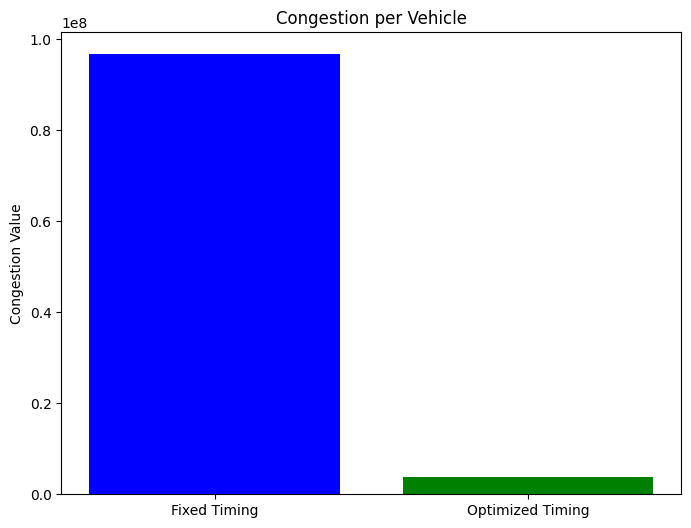

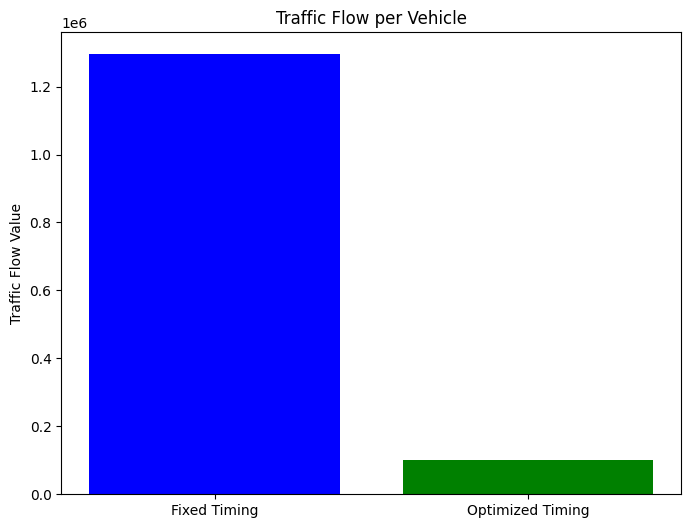

In [137]:
fixed_vehicles_processed = df_fixed['vehid'].nunique()
optimized_vehicles_processed = df_optimized['vehid'].nunique()

fixed_time = (pd.to_datetime(df_fixed['dateandtime'].max()) - pd.to_datetime(df_fixed['dateandtime'].min())).total_seconds() / 60
optimized_time = (pd.to_datetime(df_optimized['dateandtime'].max()) - pd.to_datetime(df_optimized['dateandtime'].min())).total_seconds() / 60

fixed_traffic_flow = df_fixed['traffic_flow_rate'].sum()
optimized_traffic_flow = df_optimized['traffic_flow_rate'].sum()

fixed_avg_waiting_time = df_fixed['average_waiting_time'].mean()
optimized_avg_waiting_time = df_optimized['average_waiting_time'].mean()

fixed_total_congestion = df_fixed['lane_congestion'].sum()
optimized_total_congestion = df_optimized['lane_congestion'].sum()

fixed_congestion_per_vehicle = fixed_total_congestion / fixed_vehicles_processed
optimized_congestion_per_vehicle = optimized_total_congestion / optimized_vehicles_processed

fixed_flow_per_vehicle = fixed_traffic_flow / fixed_vehicles_processed
optimized_flow_per_vehicle = optimized_traffic_flow / optimized_vehicles_processed

plt.figure(figsize=(8, 6))
metrics = ['Fixed Timing', 'Optimized Timing']
congestion_values = [fixed_congestion_per_vehicle, optimized_congestion_per_vehicle]

plt.bar(metrics, congestion_values, color=['blue', 'green'])
plt.title('Congestion per Vehicle')
plt.ylabel('Congestion Value')
plt.show()

plt.figure(figsize=(8, 6))
traffic_flow_values = [fixed_flow_per_vehicle, optimized_flow_per_vehicle]

plt.bar(metrics, traffic_flow_values, color=['blue', 'green'])
plt.title('Traffic Flow per Vehicle')
plt.ylabel('Traffic Flow Value')
plt.show()


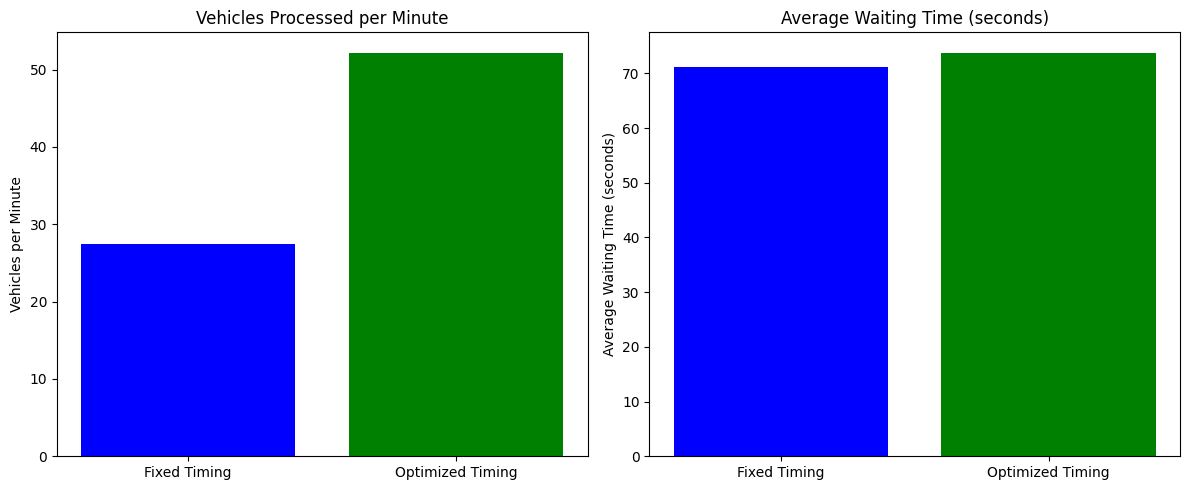

In [138]:
metrics = ['Vehicles per Minute', 'Average Waiting Time']
fixed_values = [27.42, 71.09]  
optimized_values = [52.21, 73.80]


fig, axs = plt.subplots(1, 2, figsize=(12, 5))


axs[0].bar(['Fixed Timing', 'Optimized Timing'], [fixed_values[0], optimized_values[0]], color=['blue', 'green'])
axs[0].set_title('Vehicles Processed per Minute')
axs[0].set_ylabel('Vehicles per Minute')


axs[1].bar(['Fixed Timing', 'Optimized Timing'], [fixed_values[1], optimized_values[1]], color=['blue', 'green'])
axs[1].set_title('Average Waiting Time (seconds)')
axs[1].set_ylabel('Average Waiting Time (seconds)')

plt.tight_layout()
plt.show()


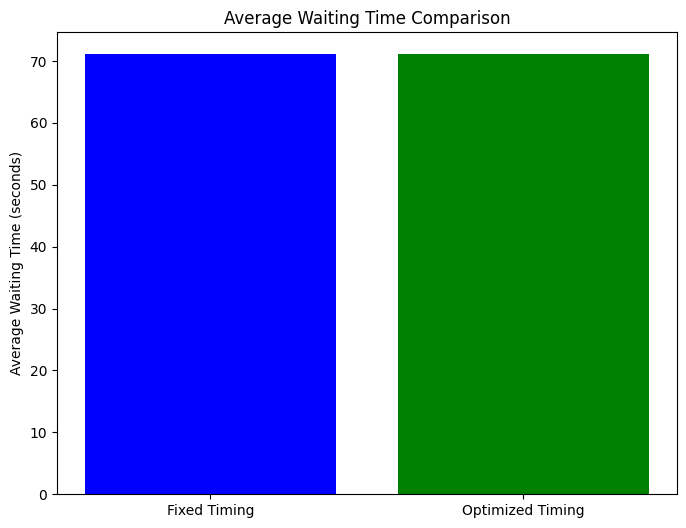

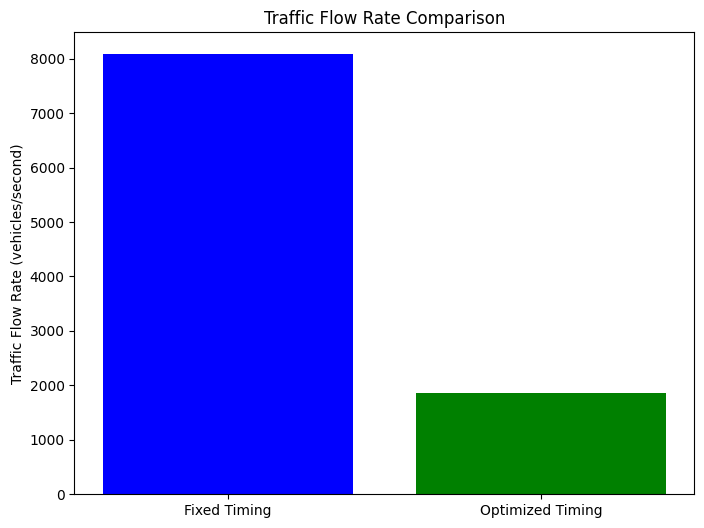

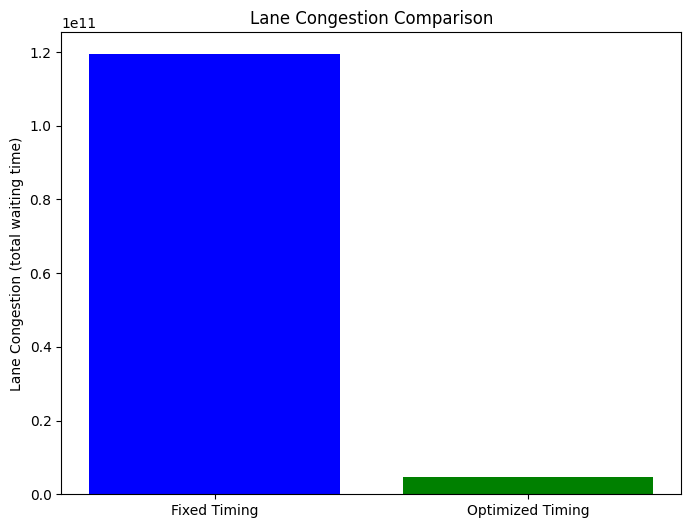

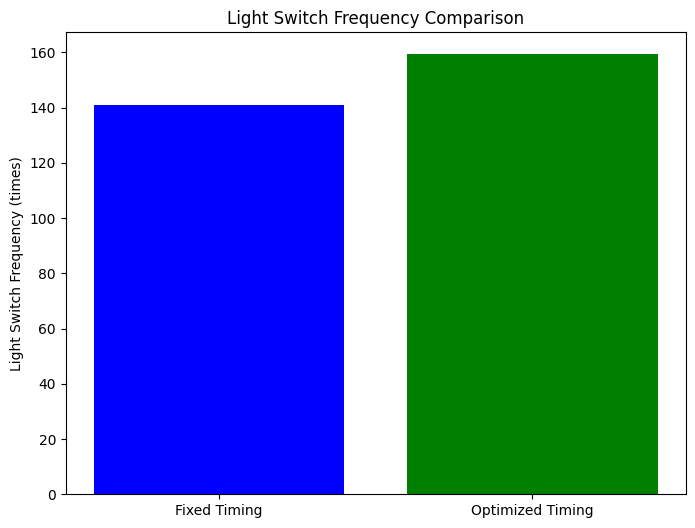

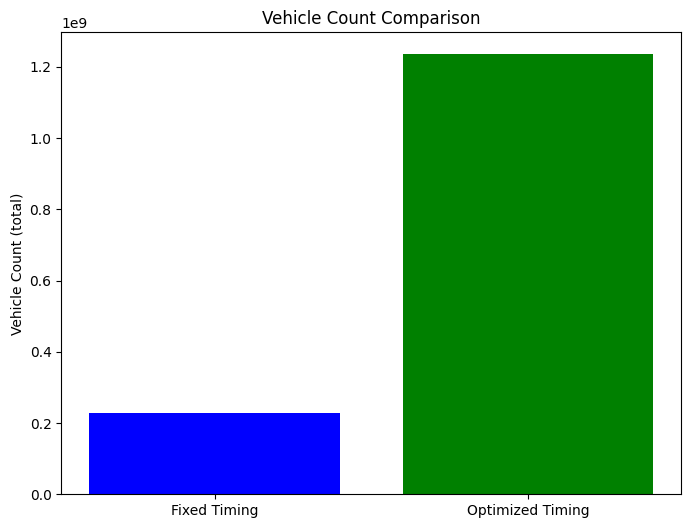

In [142]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Aggregate key metrics for both fixed and optimized datasets
# Average Waiting Time (mean of 'average_waiting_time' column)
avg_waiting_time_fixed = df_fixed['average_waiting_time'].mean()
avg_waiting_time_optimized = df_optimized['average_waiting_time'].mean()

# Traffic Flow Rate (mean of 'traffic_flow_rate' column)
traffic_flow_rate_fixed = df_fixed['traffic_flow_rate'].mean()
traffic_flow_rate_optimized = df_optimized['traffic_flow_rate'].mean()

# Lane Congestion (sum of 'lane_congestion' column)
lane_congestion_fixed = df_fixed['lane_congestion'].sum()
lane_congestion_optimized = df_optimized['lane_congestion'].sum()

# Light Switch Frequency (mean of 'light_switch_frequency' column)
light_switch_frequency_fixed = df_fixed['light_switch_frequency'].mean()
light_switch_frequency_optimized = df_optimized['light_switch_frequency'].mean()

# Vehicle Count (sum of 'vehicle_count' column)
vehicle_count_fixed = df_fixed['vehicle_count'].sum()
vehicle_count_optimized = df_optimized['vehicle_count'].sum()

# Step 2: Plot the bar charts

# 1. Plot Average Waiting Time
plt.figure(figsize=(8, 6))
plt.bar(['Fixed Timing', 'Optimized Timing'], 
        [avg_waiting_time_fixed, avg_waiting_time_optimized], 
        color=['blue', 'green'])
plt.title('Average Waiting Time Comparison')
plt.ylabel('Average Waiting Time (seconds)')
plt.show()

# 2. Plot Traffic Flow Rate
plt.figure(figsize=(8, 6))
plt.bar(['Fixed Timing', 'Optimized Timing'], 
        [traffic_flow_rate_fixed, traffic_flow_rate_optimized], 
        color=['blue', 'green'])
plt.title('Traffic Flow Rate Comparison')
plt.ylabel('Traffic Flow Rate (vehicles/second)')
plt.show()

# 3. Plot Lane Congestion
plt.figure(figsize=(8, 6))
plt.bar(['Fixed Timing', 'Optimized Timing'], 
        [lane_congestion_fixed, lane_congestion_optimized], 
        color=['blue', 'green'])
plt.title('Lane Congestion Comparison')
plt.ylabel('Lane Congestion (total waiting time)')
plt.show()

# 4. Plot Light Switch Frequency
plt.figure(figsize=(8, 6))
plt.bar(['Fixed Timing', 'Optimized Timing'], 
        [light_switch_frequency_fixed, light_switch_frequency_optimized], 
        color=['blue', 'green'])
plt.title('Light Switch Frequency Comparison')
plt.ylabel('Light Switch Frequency (times)')
plt.show()

# 5. Plot Vehicle Count
plt.figure(figsize=(8, 6))
plt.bar(['Fixed Timing', 'Optimized Timing'], 
        [vehicle_count_fixed, vehicle_count_optimized], 
        color=['blue', 'green'])
plt.title('Vehicle Count Comparison')
plt.ylabel('Vehicle Count (total)')
plt.show()


In [146]:
print("the fixed duration: ",fixed_duration)
print("the optimized duration: ",optimized_duration)

the fixed duration:  45.083333333333336
the optimized duration:  26.6
